In [1]:
#Instalação de bibliotecas utilizadas no projeto
!pip install lightgbm catboost xgboost

In [2]:
#Importação de bibliotecas utilizadas no projeto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
)

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, recall_score
)

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import randint

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

In [3]:
#Carregamento do dataset para treinamento de gênero
train_df = pd.read_csv('train.csv')

#Quantidade linhas e colunas
train_df.shape

(17996, 17)

In [4]:
#Visualização do dataset
train_df.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [5]:
#Informações do dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [6]:
#Campos nulos
train_df.isnull().sum()

,0
Artist Name,0
Track Name,0
Popularity,428
danceability,0
energy,0
key,2014
loudness,0
mode,0
speechiness,0
acousticness,0


In [7]:
#Tratamento para preenchimento de dados nulos, ou seja que não estão presentes no dataset
train_df['Popularity'] = train_df['Popularity'].fillna(train_df['Popularity'].median())
train_df['key'] = train_df['key'].fillna(train_df['key'].mode()[0])
train_df['instrumentalness'] = train_df['instrumentalness'].fillna(0)

In [8]:
#Rever se tem Campos nulos
train_df.isnull().sum()

,0
Artist Name,0
Track Name,0
Popularity,0
danceability,0
energy,0
key,0
loudness,0
mode,0
speechiness,0
acousticness,0


In [9]:
#Remover colunas de viés e são irrelevantes na clasisifcação de gênero:
# popularity: pode causar viés na classificação de gênero, pois classificar um gênero não deveria depender da popularidade da música, mas sim as caracteristicas da composição da música
# duration_in min/ms: pode causar um viés na classifcação de gênero, pois classificar um gênero não deveria depender do tempo que a música tem,  mas sim as caracteristicas da composição da música
# liveness: Se a música é gravada ao vivo ou não, todos os gêneros podem ser ao vivo e ter elementos semelhantes, então não se faz relevante para a classificação
# loudness: O volume em decibéis, está ligado mais a masterização, ou seja não influencia em gênero e pode causar classificações erradas
# key: é uma informação que pode váriar dentro do próprio gênero, podendo se tornar um dado que causa problemas para identificar o gênero, além disso tem um grau baixo de correção com gênero
train_df = train_df.drop(columns=['Popularity', 'duration_in min/ms', 'liveness', 'loudness', 'key'])

In [10]:
# Criar instâncias do LabelEncoder
label_encoder_track = LabelEncoder()
label_encoder_artist = LabelEncoder()

#Aplicar o Label Encoding nas colunas
train_df['Track Name'] = label_encoder_track.fit_transform(train_df['Track Name'])
train_df['Artist Name'] = label_encoder_artist.fit_transform(train_df['Artist Name'])

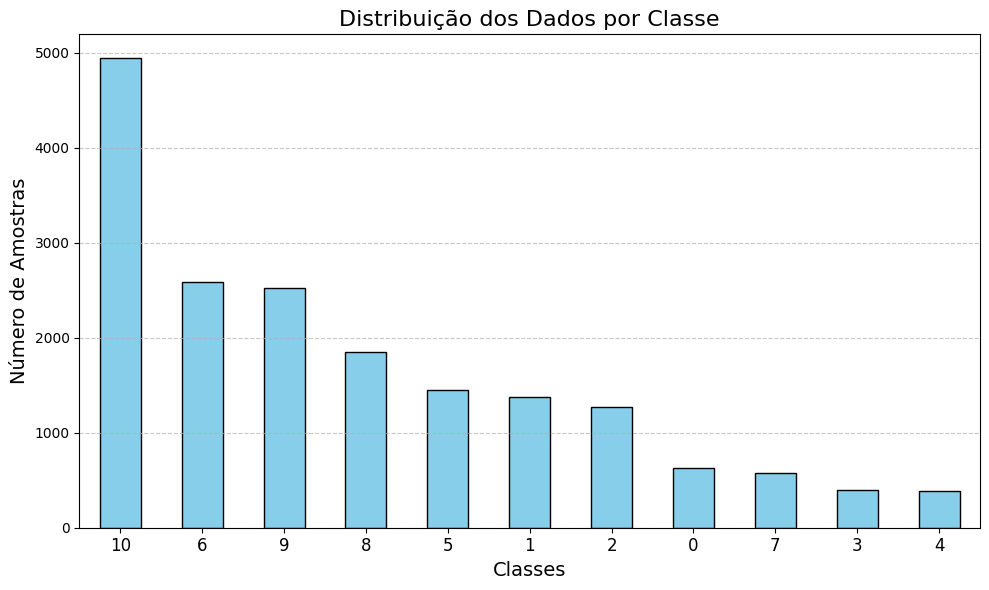

In [11]:
#Mostra a quantidade de ocorrências por classe
distribuicao = train_df['Class'].value_counts()

plt.figure(figsize=(10, 6))
distribuicao.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuição dos Dados por Classe', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Número de Amostras', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
#Filtra o modelo para só pop e rock
train_df = train_df[train_df['Class'].isin([9, 10])]

Acurácia: 0.81


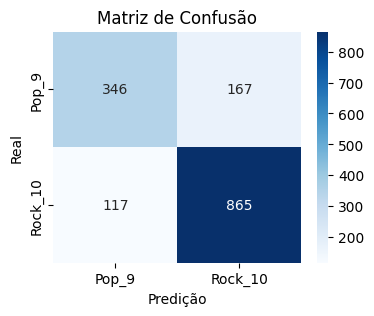


Relatório de Classificação:
              precision    recall  f1-score   support

           9       0.75      0.67      0.71       513
          10       0.84      0.88      0.86       982

    accuracy                           0.81      1495
   macro avg       0.79      0.78      0.78      1495
weighted avg       0.81      0.81      0.81      1495

Recall: 0.78


In [13]:
#Primeiro treinamento
X = train_df.drop(columns=['Class'])
y = train_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.2f}")

#Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pop_9', 'Rock_10'], yticklabels=['Pop_9', 'Rock_10'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

#Relatório
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

#Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Treinando modelo: KNN
Acurácia: 0.67
Recall: 0.60

Relatório de Classificação:
              precision    recall  f1-score   support

           9       0.52      0.38      0.44       513
          10       0.72      0.82      0.76       982

    accuracy                           0.67      1495
   macro avg       0.62      0.60      0.60      1495
weighted avg       0.65      0.67      0.65      1495



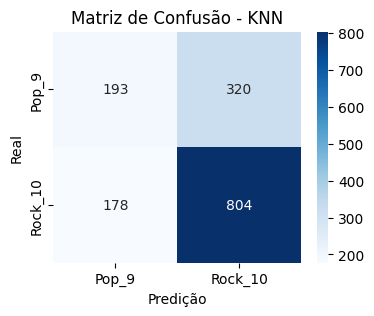



Treinando modelo: Decision Tree
Acurácia: 0.74
Recall: 0.72

Relatório de Classificação:
              precision    recall  f1-score   support

           9       0.62      0.63      0.63       513
          10       0.81      0.80      0.80       982

    accuracy                           0.74      1495
   macro avg       0.71      0.72      0.71      1495
weighted avg       0.74      0.74      0.74      1495



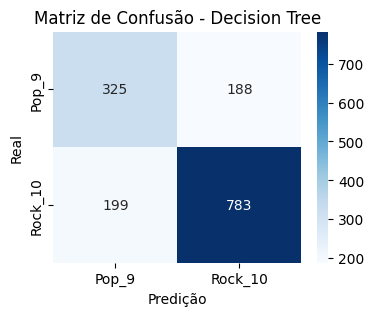



Treinando modelo: Random Forest
Acurácia: 0.81
Recall: 0.78

Relatório de Classificação:
              precision    recall  f1-score   support

           9       0.75      0.67      0.71       513
          10       0.84      0.88      0.86       982

    accuracy                           0.81      1495
   macro avg       0.79      0.78      0.78      1495
weighted avg       0.81      0.81      0.81      1495



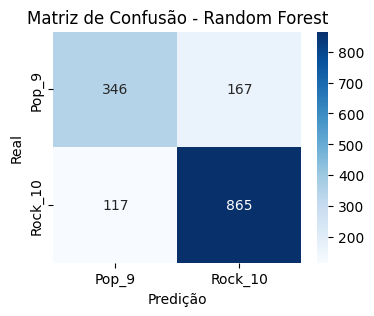

In [14]:
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Treinamento, predição e avaliação para cada modelo
for model_name, model in models.items():
    print(f"Treinando modelo: {model_name}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Acurácia
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {accuracy:.2f}")

    # Recall
    recall = recall_score(y_test, y_pred, average='macro')
    print(f"Recall: {recall:.2f}")

    # Relatório de Classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pop_9', 'Rock_10'], yticklabels=['Pop_9', 'Rock_10'])
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.show()
    print("\n" + "="*50 + "\n")

In [ ]:
#Testando combinações diferentes de hiper parametros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X, y)
print("Melhores parâmetros:", grid_search.best_params_)
model = grid_search.best_estimator_

{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
#Testando combinações diferentes de hiepr parametros
param_dist = {
    'n_estimators': randint(50, 200),  # Número de árvores, valores aleatórios entre 50 e 200
    'max_depth': [None, 10, 20, 30],   # Profundidade máxima da árvore
    'min_samples_split': randint(2, 10),  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': randint(1, 5)  # Número mínimo de amostras em uma folha
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,  # Espaço de busca
    n_iter=50,                       # Número de combinações a testar
    cv=5,                            # Validação cruzada com 5 folds
    random_state=42,
    n_jobs=-1                        # Paralelismo para acelerar o treinamento
)

random_search.fit(X, y)

print("Melhores parâmetros:", random_search.best_params_)
best_model = random_search.best_estimator_

Melhores parâmetros: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 141}



Acurácia para os parâmetros {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 141}: 0.81


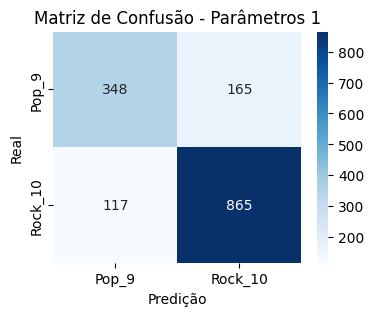


Relatório de Classificação - Parâmetros 1:
              precision    recall  f1-score   support

           9       0.75      0.68      0.71       513
          10       0.84      0.88      0.86       982

    accuracy                           0.81      1495
   macro avg       0.79      0.78      0.79      1495
weighted avg       0.81      0.81      0.81      1495

Recall - Parâmetros 1: 0.78

Acurácia para os parâmetros {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}: 0.82


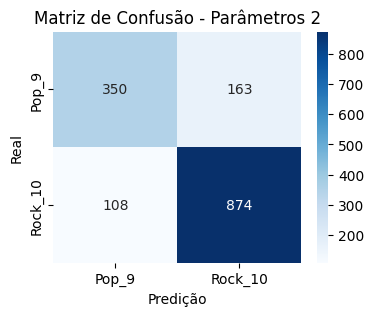


Relatório de Classificação - Parâmetros 2:
              precision    recall  f1-score   support

           9       0.76      0.68      0.72       513
          10       0.84      0.89      0.87       982

    accuracy                           0.82      1495
   macro avg       0.80      0.79      0.79      1495
weighted avg       0.82      0.82      0.82      1495

Recall - Parâmetros 2: 0.79


In [15]:
# Configuração 1 - Hiperparâmetros fornecidos
params_1 = {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 141}
model_1 = RandomForestClassifier(**params_1, random_state=42)
model_1.fit(X_train, y_train)

# Predição
y_pred_1 = model_1.predict(X_test)

# Acurácia
accuracy_1 = accuracy_score(y_test, y_pred_1)
print(f"\nAcurácia para os parâmetros {params_1}: {accuracy_1:.2f}")

# Matriz de Confusão
cm_1 = confusion_matrix(y_test, y_pred_1)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', xticklabels=['Pop_9', 'Rock_10'], yticklabels=['Pop_9', 'Rock_10'])
plt.title('Matriz de Confusão - Parâmetros 1')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

# Relatório de Classificação
print("\nRelatório de Classificação - Parâmetros 1:")
print(classification_report(y_test, y_pred_1))

# Recall
recall_1 = recall_score(y_test, y_pred_1, average='macro')
print(f"Recall - Parâmetros 1: {recall_1:.2f}")

# Configuração 2 - Hiperparâmetros fornecidos
params_2 = {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
model_2 = RandomForestClassifier(**params_2, random_state=42)
model_2.fit(X_train, y_train)

# Predição
y_pred_2 = model_2.predict(X_test)

# Acurácia
accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"\nAcurácia para os parâmetros {params_2}: {accuracy_2:.2f}")

# Matriz de Confusão
cm_2 = confusion_matrix(y_test, y_pred_2)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', xticklabels=['Pop_9', 'Rock_10'], yticklabels=['Pop_9', 'Rock_10'])
plt.title('Matriz de Confusão - Parâmetros 2')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

# Relatório de Classificação
print("\nRelatório de Classificação - Parâmetros 2:")
print(classification_report(y_test, y_pred_2))

# Recall
recall_2 = recall_score(y_test, y_pred_2, average='macro')
print(f"Recall - Parâmetros 2: {recall_2:.2f}")

In [16]:
train_df["Class"] = train_df["Class"].map({9: 0, 10: 1})

# Verificando se o mapeamento está correto
print(train_df["Class"].value_counts())

Class
1    4949
0    2524
Name: count, dtype: int64


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4949, number of negative: 2524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 7473, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.662251 -> initscore=0.673341
[LightGBM] [Info] Start training from score 0.673341
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3959, number of negative: 2019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2302
[LightGBM] [Info] Number of data points in the train set: 5978, number of used feature

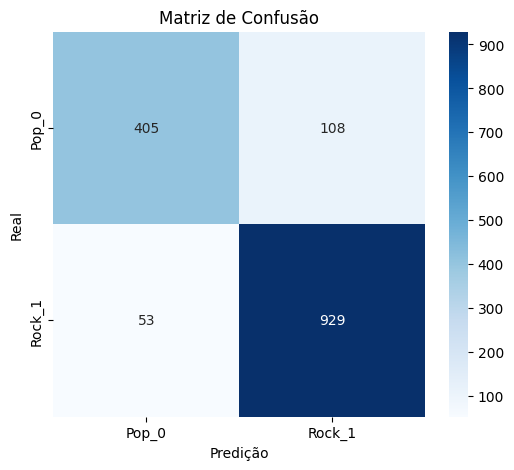


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       513
           1       0.90      0.95      0.92       982

    accuracy                           0.89      1495
   macro avg       0.89      0.87      0.88      1495
weighted avg       0.89      0.89      0.89      1495

Recall: 0.87


In [17]:
#Definindo os estimadores
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('gb', GradientBoostingClassifier(n_estimators=100)),
    ('lgb', LGBMClassifier(n_estimators=100)),
    ('cat', CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, verbosity=0)),
]

final_estimator = LogisticRegression()

#Usando StackingClassifier com diferentes modelos
X = train_df.drop(columns=['Class'])
y = train_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

stacking_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
stacking_model.fit(X, y)

#Previsões
y_pred = stacking_model.predict(X_test)

#Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo Stacking: {accuracy:.2f}")

#Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pop_0', 'Rock_1'], yticklabels=['Pop_0', 'Rock_1'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

#Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

#Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4949, number of negative: 4949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 9898, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3959, number of negative: 3959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 7918, number of u

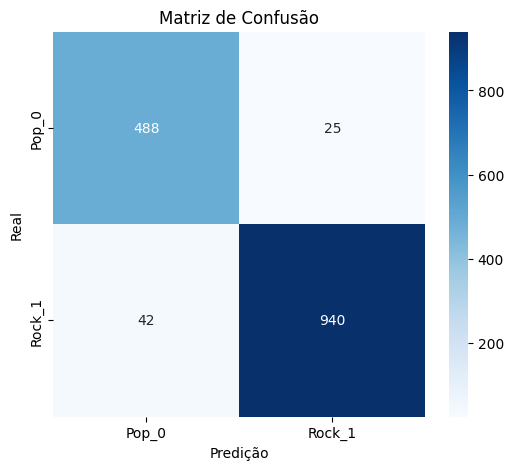


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       513
           1       0.97      0.96      0.97       982

    accuracy                           0.96      1495
   macro avg       0.95      0.95      0.95      1495
weighted avg       0.96      0.96      0.96      1495

Recall: 0.95


In [18]:
smote = SMOTE(random_state=42)
X = train_df.drop(columns=['Class'])
y = train_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Definindo os estimadores
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('gb', GradientBoostingClassifier(n_estimators=100)),
    ('lgb', LGBMClassifier(n_estimators=100)),
    ('cat', CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)),
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, verbosity=0)),
]

final_estimator = LogisticRegression()

#Usando StackingClassifier com diferentes modelos
stacking_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
stacking_model.fit(X_res, y_res)

#Previsões
y_pred = stacking_model.predict(X_test)

#Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo Stacking: {accuracy:.2f}")

#Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pop_0', 'Rock_1'], yticklabels=['Pop_0', 'Rock_1'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

#Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

#Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4949, number of negative: 4949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 9898, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

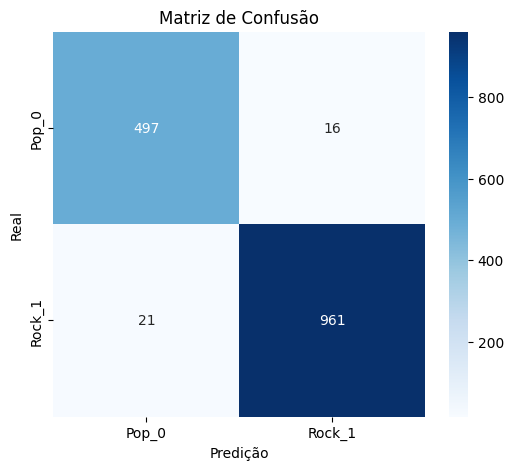


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       513
           1       0.98      0.98      0.98       982

    accuracy                           0.98      1495
   macro avg       0.97      0.97      0.97      1495
weighted avg       0.98      0.98      0.98      1495

Recall do modelo Stacking: 0.97

Estatísticas do modelo rf:
Acurácia: 0.99
Recall: 0.99
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       513
           1       0.99      0.99      0.99       982

    accuracy                           0.99      1495
   macro avg       0.99      0.99      0.99      1495
weighted avg       0.99      0.99      0.99      1495


Estatísticas do modelo gb:
Acurácia: 0.99
Recall: 0.98
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       513
        

In [203]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 10]
}

param_grid_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 10]
}

param_grid_cat = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 6, 10]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 10]
}

# Modelos com GridSearchCV
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)
xgb = XGBClassifier(random_state=42)

# Realizando GridSearch para encontrar os melhores hiperparâmetros
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_gb = GridSearchCV(gb, param_grid_gb, cv=3, scoring='accuracy', n_jobs=-1)
grid_lgb = GridSearchCV(lgb, param_grid_lgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_cat = GridSearchCV(cat, param_grid_cat, cv=3, scoring='accuracy', n_jobs=-1)
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)

# Ajustando os modelos
grid_rf.fit(X_res, y_res)
grid_gb.fit(X_res, y_res)
grid_lgb.fit(X_res, y_res)
grid_cat.fit(X_res, y_res)
grid_xgb.fit(X_res, y_res)

# Mostrando os melhores parâmetros
print(f"Melhores parâmetros para RandomForest: {grid_rf.best_params_}")
print(f"Melhores parâmetros para GradientBoosting: {grid_gb.best_params_}")
print(f"Melhores parâmetros para LGBM: {grid_lgb.best_params_}")
print(f"Melhores parâmetros para CatBoost: {grid_cat.best_params_}")
print(f"Melhores parâmetros para XGBoost: {grid_xgb.best_params_}")

# Definindo os estimadores com os melhores parâmetros
estimators = [
    ('rf', grid_rf.best_estimator_),
    ('gb', grid_gb.best_estimator_),
    ('lgb', grid_lgb.best_estimator_),
    ('cat', grid_cat.best_estimator_),
    ('xgb', grid_xgb.best_estimator_),
]

#Meta-modelo: Regressão Logística
final_estimator = LogisticRegression()

#Usando StackingClassifier com os melhores estimadores
#Treinando com dados balanceados
stacking_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
stacking_model.fit(X_res, y_res)

#Previsões
y_pred = stacking_model.predict(X_test)

#Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo Stacking: {accuracy:.2f}")

#Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pop_0', 'Rock_1'], yticklabels=['Pop_0', 'Rock_1'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

#Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

#Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall do modelo Stacking: {recall:.2f}")

#Estatísticas dos Modelos Individuais
for name, model in estimators:
    y_pred_individual = model.predict(X_test)
    print(f"\nEstatísticas do modelo {name}:")
    print(f"Acurácia: {accuracy_score(y_test, y_pred_individual):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred_individual, average='macro'):.2f}")
    print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_individual)}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4949, number of negative: 4949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 9898, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

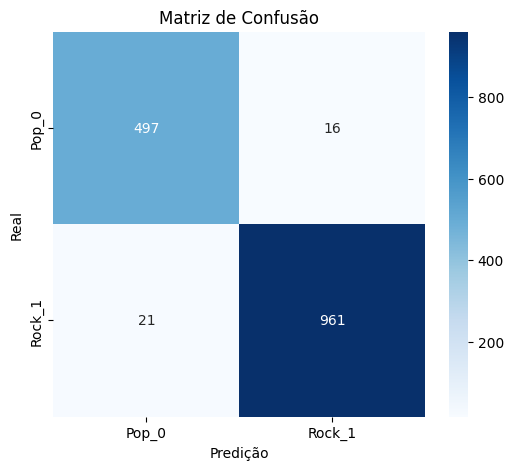


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       513
           1       0.98      0.98      0.98       982

    accuracy                           0.98      1495
   macro avg       0.97      0.97      0.97      1495
weighted avg       0.98      0.98      0.98      1495

Recall: 0.97


In [19]:
smote = SMOTE(random_state=42)
X = train_df.drop(columns=['Class'])
y = train_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Definindo os estimadores
estimators = [
    ('rf', RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)),
    ('gb', GradientBoostingClassifier(learning_rate=0.1, max_depth=10, n_estimators=200, random_state=42)),
    ('lgb', LGBMClassifier(learning_rate=0.1, max_depth=6, n_estimators=200, random_state=42)),
    ('cat', CatBoostClassifier(depth=10, iterations=200, learning_rate=0.1, random_state=42, verbose=0)),
    ('xgb', XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=200, random_state=42)),
]

final_estimator = LogisticRegression()

#Usando StackingClassifier com diferentes modelos
stacking_model = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
stacking_model.fit(X_res, y_res)

#Previsões
y_pred = stacking_model.predict(X_test)

#Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo Stacking: {accuracy:.2f}")

#Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pop_0', 'Rock_1'], yticklabels=['Pop_0', 'Rock_1'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

#Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

#Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

In [20]:
smote = SMOTE(random_state=42)
X = train_df.drop(columns=['Class'])
y = train_df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliação do modelo usando validação cruzada
cv_scores = cross_val_score(model, X_res, y_res, cv=kf, scoring='accuracy')

# Exibir resultados da validação cruzada
print(f'Acurácias por fold: {cv_scores}')
print(f'Acurácia média da validação cruzada: {np.mean(cv_scores):.2f}')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = cross_val_score(model, X_res, y_res, cv=cv, scoring='roc_auc')

# Exibindo os resultados
print(f'AUC-ROC por fold: {auc_scores}')
print(f'AUC-ROC médio: {auc_scores.mean():.4f}')

Acurácias por fold: [0.81969697 0.80252525 0.83383838 0.83628095 0.83880748]
Acurácia média da validação cruzada: 0.83
AUC-ROC por fold: [0.8916733  0.89254617 0.90673554 0.90508319 0.91142824]
AUC-ROC médio: 0.9015


In [21]:
# Conjunto de dados fornecido
data = [
    #Pop
    ["MC Hammer", "U Can't Touch This", 0.867, 0.517, 0, 0.0875, 0.00456, 0.000339, 0.866, 133.148, 4],
    ["R3HAB", "Whiplash - Acoustic", 0.556, 0.188, 1, 0.0316, 0.494, 0, 0.184, 138091, 4],
    #Rock
    ["Sharon Van Etten", "Comeback Kid", 0.543, 0.927, 1, 0.0755, 0.000342, 0.543, 0.354, 120097, 4],
    ["Jimmy Eat World", "All The Way (Stay)", 0.576, 0.931, 1, 0.0563, 0.00085, 0, 0.735, 133986, 4],
]

# Colunas do conjunto de dados
columns = ["Artist Name", "Track Name", "danceability", "energy", "mode", "speechiness", "acousticness", "instrumentalness", "valence", "tempo", "time_signature"]

# Criando o DataFrame
testeGeneros = pd.DataFrame(data, columns=columns)

label_encoder_artist = LabelEncoder()
label_encoder_track = LabelEncoder()

testeGeneros["Artist Name"] = label_encoder_artist.fit_transform(testeGeneros["Artist Name"])
testeGeneros["Track Name"] = label_encoder_track.fit_transform(testeGeneros["Track Name"])

# Previsão usando o modelo
y_pred = stacking_model.predict(testeGeneros)

# Exibindo os resultados
print(y_pred)

[0 0 1 1]
